In [73]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVCal
from pyuvdata import UVData
import glob
import aipy
from hera_qm import ant_metrics
from hera_cal import omni, utils, firstcal
from matplotlib.colors import LogNorm
import sys
import json
from copy import deepcopy
import omnical
%matplotlib inline 

# Data location

In [53]:
pols = ['xx','xy','yx','yy']
antpols = ['x','y']
origin = '/lustre/aoc/projects/hera/zali/HERA2015/'
time = '2457555.42443'
day = time.split('.')[0]
dataFileList = [origin + day + '/zen.' + time + '.' + pol + '.HH.uvc' for pol in pols]
ant_metrics_json = origin + day + '/IDR3_newstuff/zen.' + time + '.HH.uvc.ant_metrics.json'
fcFileList = [origin + day + '/IDR3_newstuff/zen.' + time + '.' + pol + '.HH.uvc.first.calfits' for pol in [pols[0],pols[3]]]
omnicalFile = origin + day + '/IDR3_newstuff/zen.' + time + '.HH.uvc.omni.calfits'
omniVisFile = origin + day + '/IDR3_newstuff/zen.' + time + '.HH.uvc.vis.uvfits'
fc_results_FileList = [origin + day + '/IDR3_newstuff/zen.' + time + '.' + pol + '.HH.uvc.first.calfits.rotated_metric.json' for pol in [pols[0],pols[3]]]



In [3]:
CAL_PATH = '/users/jsdillon/hera_sandbox/jsd/calfiles'
calfile = 'hsa7458_v001'
if CAL_PATH not in sys.path:
    sys.path.append(CAL_PATH)

# Load data

In [4]:
data = UVData()
data.read_miriad(dataFileList)

Altitude is not present in Miriad file, using known location values for HERA.
antenna number 112 has visibilities associated with it, but it has a position of (0,0,0)
antenna_diameters is not set. Using known values for HERA.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


# Plot raw data

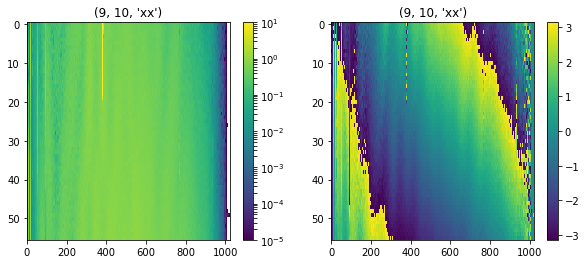

In [74]:
bl = (9,10,'xx')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(data.get_data(bl)), aspect='auto', norm=LogNorm(vmin=.00001, vmax=10))
plt.title(bl)
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(data.get_data(bl)), aspect='auto')
plt.title(bl)
plt.colorbar()


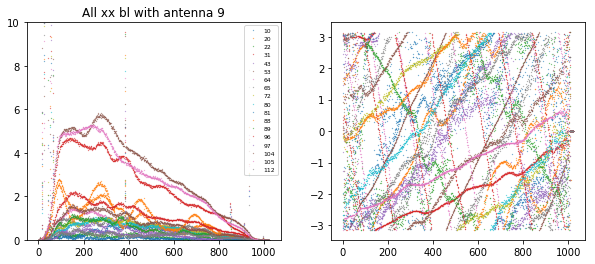

In [75]:
ants = data.get_ants()
ant1 = ants[0]
#bl = (ants[3],ants[6],'xx')
integration = 0
plt.figure(figsize=(10,4))
for ant2 in ants:
    if ant2 != ant1:
        bl = (ant1, ant2, 'xx')
        plt.subplot(121)
        plt.plot(np.abs(data.get_data(bl)[integration,:]), '.', ms=.5, label = ant2)
        plt.title('All ' + bl[2] + ' bl with antenna ' + str(ant1))
        plt.ylim([0,10])
        plt.legend(fontsize=6)
        plt.subplot(122)
        plt.plot(np.angle(data.get_data(bl)[integration,:]), '.', ms=.5)


# Print ant_metrics results

In [76]:
am = ant_metrics.load_antenna_metrics(ant_metrics_json)
print am['xants']
print am['crossed_ants']
print am['dead_ants']

[(22, 'y'), (22, 'x'), (81, 'y'), (81, 'x')]
[(22, 'y'), (22, 'x'), (81, 'y'), (81, 'x')]
[]


# Examine firstcal results

In [79]:
fc_results = {}
fc_results['x'] = json.load(open(fc_results_FileList[0],'r'))
fc_results['y'] = json.load(open(fc_results_FileList[1],'r'))
fc_delays = {}
for ant in ants:
    for antpol in antpols:
        if (ant,antpol) not in am['xants']:
            fc_delays[(ant,antpol)] = np.array(fc_results[antpol]['delays'][str(ant)+antpol]).flatten()

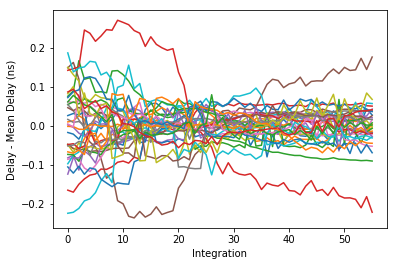

In [80]:
plt.figure()
for (ant,antpol), delays in fc_delays.items():
    plt.plot(1e9*(delays - np.mean(delays)), label=(ant,antpol))

plt.xlabel('Integration')
plt.ylabel('Delay - Mean Delay (ns)')
#plt.legend(fontsize=8)

# Examine Omnical Solutions

In [81]:
oc = UVCal()
oc.read_calfits(omnicalFile)
oc_antpols = [aipy.miriad.pol2str[index][0] for index in oc.jones_array]
oc_gains = {}

for ip, antpol in enumerate(oc_antpols):
    for ia, ant in enumerate(oc.ant_array):
        oc_gains[(ant,antpol)] = oc.gain_array[ia,0,:,:,ip]

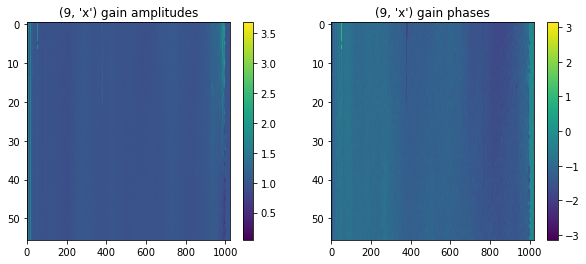

In [82]:
antenna = (ants[0],'x')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(oc_gains[antenna].T), aspect='auto')
plt.title(str(antenna) + ' gain amplitudes')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(oc_gains[antenna].T), aspect='auto')
plt.title(str(antenna) + ' gain phases')
plt.colorbar()

In [83]:
vis = UVData()
vis.read_uvfits(omniVisFile)

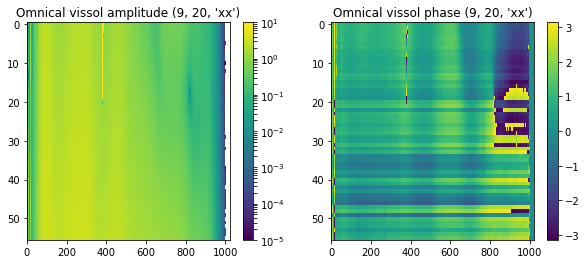

In [84]:
antpair = vis.get_antpairs()[0]
bl = (antpair[0],antpair[1],'xx')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(vis.get_data(bl)), aspect='auto', norm=LogNorm(vmin=.00001, vmax=10))
plt.title('Omnical vissol amplitude ' + str(bl))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(vis.get_data(bl)), aspect='auto')
plt.title('Omnical vissol phase ' + str(bl))
plt.colorbar()


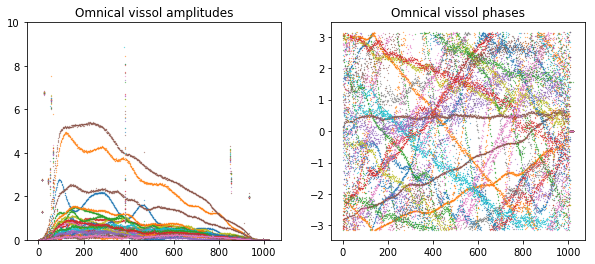

In [85]:
integration = 0
plt.figure(figsize=(10,4))
for (ant1, ant2) in vis.get_antpairs():
#    ant1, ant2 = 9,20
    bl = (ant1, ant2, 'xx')
    plt.subplot(121)
    plt.plot(np.abs(vis.get_data(bl)[integration,:]), '.', ms=.5, label = bl)
    plt.title('Omnical vissol amplitudes')
    plt.ylim([1e-5,10])
#    plt.legend(fontsize=6)
    plt.subplot(122)
    plt.title('Omnical vissol phases')
    plt.plot(np.angle(data.get_data(bl)[integration,:]), '.', ms=.5)
plt.savefig('test.png')

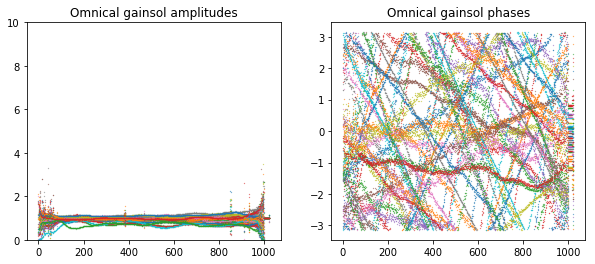

In [94]:
integration = 0
plt.figure(figsize=(10,4))
for ant,antpol in oc_gains.keys():
    plt.subplot(121)
    plt.plot(np.abs(oc_gains[ant,antpol][:,integration]), '.', ms=.5, label = bl)
    plt.title('Omnical gainsol amplitudes')
    plt.ylim([1e-5,10])
    plt.subplot(122)
    plt.title('Omnical gainsol phases')
    plt.plot(np.angle(oc_gains[ant,antpol][:,integration]), '.', ms=.5)